<h1><center>Questions sur l'Ajustement de Valorisation IPV</center></h1>


# Introduction

Le but de cet exercice est d'impliciter la volatilité du sous jacent dans le modèle de Black Scholes et de faire un Ajustement de Valorisation à Valeur Principale d'un call *(le prix que nous donne le pricer)* pour s'approcher de la **Juste Valeur**.

$$\text{Juste Valeur}=\text{Valorisation Principale}+\text{Ajustement de Valorisation (IPV)}$$

Soit $C(\sigma)$ le prix fourni par le pricer d'un call européen de sous jacent une action $A$ dont le prix est $S_0$ à l'émission du contrat, de strike $K=100$ et de maturité $T=1$ an et $C_m$ le prix consensus d'un call avec les mêmes caractéristiques founi par Totem.

On définit la fonction $f$ comme suit :

$$f(\sigma)=C(\sigma)-C_m$$

L'objectif est alors de trouver $\sigma '$ telle que 

$$f(\sigma ')=C(\sigma ')-C_m=0$$

Pour faire notre premiere éstimation du prix de ce call nous avons utilisé une volatilité historique $\sigma_h=0.3$

Pour trouver $\sigma '$ nous allons utiliser l'algorithme de Newton Raphson

# Modèle de Black Scholes

## Calcul du taux d'actualisation 

On considère une obligation de maturité M=5ans un notionnel N=100.
On suppose que le coupon de l’obligation est de la forme c_0=ref + s_0
Avec ref un taux de référence par exemple le taux de rendement d’une obligation émise par l’état américain.
A l’émission de l’obligation on actualise les flux future avec le taux c_0=ref + s_0 pour être au pair (Question?)

On a alors le prix initial de l’obligation :
 $$ \pi_0=\pi(s_0)=N.\sum_{i=0}^M B(t_i)(ref+s_0)+N.B(t_n)$$
 
 avec,
 
 $$B(t_i)=\frac{1}{(1+ref+s_0)^{t_i}}$$
 
 On pose maintenant 
 
 $$\pi(s)=N.\sum_{i=0}^M B(t_i)(ref+s)+N.B(t_n)$$
 
 On a alors,
 
  $$\pi'(s)=N.\sum_{i=0}^M B(t_i)$$
  
Etant donné un prix $π_{mkt}$ on peut trouver $s_{mkt}$ tel que 
$$\pi(s_{mkt})=π_{mkt}=N.\sum_{i=0}^M B(t_i)(ref+s_{mkt})+N.B(t_n)$$
donc
$$s_{mkt}=\frac{\frac{π_{mkt}}{N}-B(t_n)-ref.\sum_{i=0}^M B(t_i)}{\sum_{i=0}^M B(t_i)}$$

On a 

In [1]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
OneBP = 0.0001

refRate = 250 * OneBP
s0 = 75 * OneBP

coupon0 = refRate + s0

ParDiscount = coupon0

Notional = 100
Maturity = 1


def BondPrice(refrate, spread, discount, maturity, notional):
    leg = sum([(refrate + spread) / (1 + discount) ** i for i in range(1, maturity + 1)])
    discountEnd = 1 / (1 + discount) ** maturity
    return (leg + discountEnd) * notional
    


def dBondPrice(discount, maturity, notional):
    return notional * sum([1 / (1 + discount) ** i for i in range(1, maturity + 1)])




def GetSpreadFromPrice(refrate, discount, maturity, notional, price):
    leg = sum([refrate / (1 + discount) ** i for i in range(1, maturity + 1)])
    bpv = sum([1 / (1 + discount) ** i for i in range(1, maturity + 1)])
    discountEnd = 1 / (1 + discount) ** maturity
    return (price / notional - discountEnd - leg) / bpv
    pass



initialPrice = BondPrice(refRate, s0, ParDiscount, Maturity, Notional)

delta = 160 * OneBP

newPrice = BondPrice(refRate, s0 + delta, ParDiscount, Maturity, Notional)

sensi = dBondPrice(ParDiscount, Maturity, Notional)

TehoSpread = GetSpreadFromPrice(refRate, ParDiscount, Maturity, Notional, newPrice) / OneBP

print(f"New price :{newPrice}")

print(f"Initial price + delta * sensi :{initialPrice + delta * sensi}")

print(f"theoSpread - spread0 :{TehoSpread-s0/OneBP}")
print(f"market spread - spread0 :{delta/OneBP}")

MarketRate=(refRate+TehoSpread*OneBP)
print(MarketRate)

New price :101.5496368038741
Initial price + delta * sensi :101.5496368038741
theoSpread - spread0 :160.00000000000065
market spread - spread0 :160.0
0.04850000000000007


Je suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

Avec

$$X_t=ln(S_t)$$

Je trouve que

$$dX_t=(r-\frac{\sigma^2}{2})dt+\sigma dB_t$$

Donc

$$X_t=X_0+(r-\frac{\sigma^2}{2})t+\sigma B_t$$

Alors $\forall t\geq 0,$

$$S_t(\sigma)=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma B_t\right\}=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma \sqrt{t} G\right\}$$

Le prix d'un call $C$ s'ecrit sous la forme suivante:

$$\begin{align*}
C(\sigma)&=\mathbb{E}\big\{e^{-rT}(S_T(\sigma)-K)_+\big\}\\
\\
&=\mathbb{E}\big\{\mathbb{1}_{S_T(\sigma)-K>0}e^{-rT}(S_T(\sigma)-K)\big\}\\
\\
&=e^{-rT}\mathbb{E}\big\{S_T(\sigma)\mathbb{1}_{S_T(\sigma)-K>0}\big\}+Ke^{-rT}\mathbb{P}\big\{S_T(\sigma)-K>0\big\}
\end{align*}$$

J'ai d'un coté

$$\begin{align*}
\mathbb{P}\big\{S_T(\sigma)-K>0\big\}&=\mathbb{P}\big\{(r-\frac{\sigma^2}{2})T+\sigma B_T>ln(\frac{K}{S_0})\big\}\\
\\
&=\mathbb{P}\big\{G>-d_2\big\}
\end{align*}$$

Et vu que $-G$ et $G$ suivent la meme loi,

$$\mathbb{P}\big\{S_T(\sigma)-K>0\big\}=\mathbb{P}\big\{G<d_2\big\}=N(d_2)$$

D'un autre coté j'ai,

$$\begin{align*}
\mathbb{E}\left\{S_T(\sigma)\mathbb{1}_{S_T(\sigma)-K>0}\right\}&=S_0\mathbb{E}\left\{ e^{(r-\frac{\sigma^2}{2})T+\sigma B_T} \mathbb{1}_{G>d_2}\right\}\\
\\
&=\int_{\mathbb{R}}\mathbb{1}_{G>x}e^{-\frac{x^2}{2}T+\sigma \sqrt{T} x-\frac{\sigma^2}{2}T}\frac{dx}{\sqrt{2\pi}} \\
\\
&=\int_{-d2}^{+\infty}e^{-\frac{x^2}{2}}\\
\\
&=S_0N(d1)
\end{align*}$$

Finalement je trouve que :

$$C(\sigma)=S_0N(d_1)-Ke^{-rT}N(d_2)$$

Où

$$\begin{cases}
      r \text{ : taux d'actualisation} & \\
      \sigma \text{ : la volatilité} & \\
      N \text{: la fonction de répartition de la loi normale}
    \end{cases}$$

Et

$$d_1=\frac{ln\left(\frac{S_0}{K}\right)+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} \text{ et } d_2=d_1-\sigma\sqrt{T}$$

In [3]:
# !pip install numpy
# !pip install scipy

In [4]:
T=1
S_0=100
r=MarketRate
sigma_h=0.3
K=100
C_m=10


def d1(x):
    return (1/(x*np.sqrt(T)))*(np.log(S_0/K)+(r+0.5*x**2)*T)


def d2(x):
    return d1(x)-x*np.sqrt(T)


def call_ferme(x):
    return S_0*norm.cdf(d1(x))-K*np.exp(-r*T)*norm.cdf(d2(x))

call_ferme(sigma_h)


14.159052097079396

On va chercher alors la racine de la fonction $f$. Pour faire cela nous allons utiliser l'algorithme de Newton Raphson.

------------------------------------------------------------------

**Définiton :**

On utilise l'algorithme de Newton Raphson pour trouver la racine d'une fonction $f$ et est définit itérativement de la manière suivante
 $$\begin{cases}
      x_0=v & \\
      x_{n+1}=x_{n}-\frac{f(x_n)}{f'(x_n)} & 
    \end{cases}$$
    
    
-----------------------------------------------------------------


On a

$$f(\sigma)=C(\sigma)-C_m=S_0N(d_1)-Ke^{-rT}N(d_2)-C_m$$

Et on peut monter que 

$$\frac{\partial f(\sigma)}{\partial \sigma}=\frac{\partial C(\sigma)}{\partial \sigma}=S_0\sqrt{T}N'(d1)$$

Où
$$N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}$$



In [5]:
def f(x):
    return call_ferme(x)-C_m


def dN(x):
    return 1/(np.sqrt(2*np.pi))*np.exp(-x**2/2)


def df(x):
    return S_0*np.sqrt(T)*dN(d1(x))



def newton_raphson(x_0,conf,max_iter,g,dg):
    x_n=x_0
    for i in range(max_iter):
        x_n_plus_1= x_n-g(x_n)/dg(x_n)
        
        if abs(x_n_plus_1-x_n)<conf:
            return x_n_plus_1
        x_n=x_n_plus_1
    print("solution non trouvé")
    
    
sigma_prim=newton_raphson(1,conf=10**-5,max_iter=1000,g=f,dg=df)

sigma_prim

0.19012900625808873

# Calcul de l'Ajusttement de Valorisation

## définition de l'IPV

La **vérification indépendante des prix** est un processus de plus en plus important pour soutenir les fonctions financières et de risque dans un large éventail d'institutions financières. Le processus de base de la IPV exige que les prix internes soient vérifiés par rapport à des sources tierces indépendantes.

Le Prudent Valuation Guidance de Bâle II définit la Vérification Indépendante des Prix comme "le processus par lequel les prix du marché ou les données d'entrée des modèles sont régulièrement vérifiés pour s'assurer de leur exactitude". La vérification des prix du marché ou des données du modèle doit être effectuée par une unité indépendante de la salle des marchés, au moins une fois par mois (ou, selon la nature du marché/de l'activité de négociation, plus fréquemment)".

## Application numérique

### Sensibilité

Le Vega est un type de grecque qui est utilisé pour calculer la sensibilité ou le taux de variation de la valeur d'un contrat d'option par rapport à la volatilité de l'actif sous-jacent. Le Vega est désigné par la lettre $V$. Essentiellement, le vega est la dérivée partielle première de la valeur du contrat d'option par rapport à la volatilité de l'actif sous-jacent.

$$V=\frac{\partial C(\sigma)}{\partial \sigma}(\sigma_h)=S_0\sqrt{T}N'(d1)$$

Où
$$N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}$$

In [6]:


sensi=S_0*np.sqrt(T)*dN(d1(sigma_h))

sensi

38.002942738993845

**Remarque :**

En pratique on utilise plutot la formule suivante pour calculer la senbilité:

$$sensi_{bis}=\frac{\partial C(\sigma)}{\partial \sigma}(\sigma_h)=\lim\limits_{\delta \sigma \rightarrow + 0}\frac{C(\sigma_h + \delta \sigma)-C(\sigma_h)}{\delta \sigma}=\frac{C(\sigma_h + 1BP)-C(\sigma_h)}{1BP}$$

In [7]:
sensi_bis=(call_ferme(sigma_h+0.0001)-call_ferme(sigma_h))/0.0001

sensi_bis

38.00296569849593

### IPV ( sensi choc )
----------------

**Définitions :**

* Dans notre contexte, la **choc** est définie comme suit :
$$\text{choc}=\sigma '-\sigma_h$$

* Et on définit l'IPV comme suit :
$$IPV=\text{choc} . sensi = (\sigma '-\sigma_h).sensi$$

---------------

In [8]:
IPV=(sigma_prim-sigma_h)*sensi

IPV

-4.175421083850204

In [9]:
call_ferme(sigma_prim)

10.000000000000206

# Ajustement de valorisation

Finalement, On calcule le proxy de la **Juste Valeur** comme suit :

$$\text{Juste Valeur}=\text{Valorisation principale}+\text{Ajustement de valorisation (IPV)}$$

In [10]:
fair_value=call_ferme(sigma_h)+IPV

fair_value

9.983631013229193

-----------------

**Remarque 1:**
On retombe bien sur une valeur proche du prix sur le marché.

--------------------

-------------------------

**Remarque 2:**

On a grace au développement de Taylor-Young au point $\sigma '$

$$C(\sigma ')\approx C(\sigma_h) +(\sigma '-\sigma_h)\partial_{\sigma}C(\sigma_h)$$

Donc

$$C_m\approx C(\sigma_h) +(\sigma '-\sigma_h).sensi$$

Donc 

$$C_m \approx \text{Juste Valeur}$$

----------------------------

# Conclusion

----------------------

**Définition :**

D'après La **norme IFRS 13**, la **"juste valeur"** (ou "fair value" en anglais) se définit comme *"le prix qui serait reçu pour la vente d'un actif ou payé pour le transfert d'un passif lors d'une transaction normale entre des participants de marché bien informés à la date d'évaluation"*.

-------------------
**Conclusion :**

D'après les remarques 1 et 2 on peut conclure que notre démarche nous permet de retrouver la Juste Valeur qui est approximativement la valeur sur le marché.

**************************

# Algorithme de Robbins Monro

soit $f$ une fonction continue telle qu'il existe $F$ une fonction et $U$ une variable aléatoire de loi connue telles que 

$$f(x)=\mathbb{E}[F(x,U)]$$

Le but de l'algorithme de Robbins Monro est de trouver, presque surement, $x'$ tel que 

$$f(x')=\mathbb{E}[F(x',U)]=0$$

-----------------
**Définition:**

Le théoreme de Robbins Monro stipule que si on définie itérativement une suite de variables aléatoires $(X_n)_{n\geq0}$:

$$\begin{cases}
      X_0= x_0 & \\
      X_{n+1}=X_n-\gamma_nF(X_n,U_{n+1}) & 
    \end{cases}$$
    
Où $(\gamma_n)_{n\geq0}$ une suite telle que $\sum_{n\geq0}\gamma_n<\infty$ et $(U_n)_{n\geq0}$ une suite de variables aléatoires idépendantes et identiquement distribuées selon la même loi que $U$.

Alors, 
$$X_n \text{ converge presque surement vers }x'$$

----------------

soit la suite de variable aleatoires 
$$V_i=e^{-rT}(S_T-K)_{+}=e^{-rT}\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G_i\right\}-K\right)_{+}=H(\sigma,G_i)$$


Alors

$$M_n=\frac{V_0+....+V_n}{n} \text{, alors, $M_n$ converge présque surement vers } C \text{ le prix d'un call}$$

J'ai avec $\gamma_n=\frac{1}{n+1}$

$$M_{n+1} = M_n -\gamma_n \left(M_n - V_{n+1}\right)=M_n -\gamma_n \left(M_n - H(\sigma,G_{n+1})\right)= M_n -\gamma_n F \left(M_n , G_{n+1}\right)$$

En effet,

$$\begin{align*}
M_{n+1}-M_n&=\frac{n\sum_{i=1}^{n+1}V_i-(n+1)\sum_{i=1}^nV_i}{n(n+1)}&\\
\\
&=\frac{V_{n+1}}{n+1}-\frac{M_n}{n+1}&\\
\\
&=-\gamma_n(M_n-V_{n+1})\\
\\
&= -\gamma_n F \left(M_n , G_{n+1}\right)\\
\\
\end{align*}$$

Soit $f(x)=x-C$  et $x'$ tel que $f(x')=x'-C=0$ et $G$ une gaussienne centrée réduite, donc $\mathbb{E}[G]=0$ et $Var[G]=1$.



Finalement je trouve que,

$$f(x)=\mathbb{E}[F(x,G)]=x-C$$


C:\Users\oessadde040723\AppData\Local\Temp\ipykernel_12892\2268543903.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/(x*np.sqrt(T)))*(np.log(S_0/K)+(r+0.5*x**2)*T)


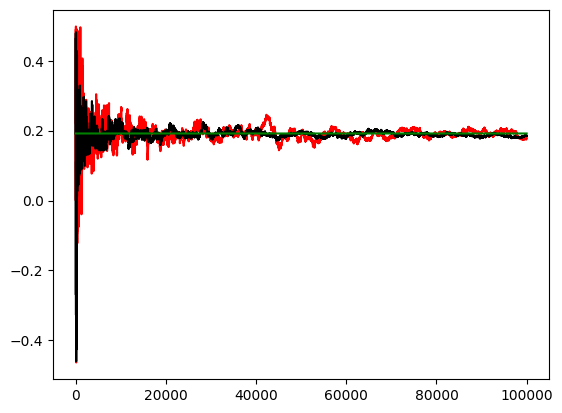

0.18060680134045023


In [169]:
MAX=5
n=100000
beta=1
c=1

def gamma(n):
    return c/(n+1)**beta

def Theta(n):
    return 1/np.sqrt(n)

def algorithme_rm(x_0,n,F,G):
    X=np.zeros(n)
    X[0]=x_0
    for i in range(0,n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
    return X
    

def algorithme_rm_chen(x_0,MAX,n,F,G):
    X=np.zeros(n);
    X[0] = x_0;
    for i in range(n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
        if(abs(X[i+1]) >= MAX): 
            X[i+1]=0 
    return X
    


    
def F_BS(x,U):
    return np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K,0)-C_m


def FP(x,g):
    u=0
    v=0
    if g<=d1(x): 
        u=S_0
    else:
        u=0
    if g<=d2(x):
        v=K*np.exp(-r*T)
    else:
        v=0
    return u-v-C_m
        
        
        
G1=np.random.normal(size=n)
G2=np.random.normal(size=n)


Y1=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,FP,G1)
Y2=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,F_BS,G2)

plt.plot(Y1,'red')
plt.plot(Y2,'black')
plt.plot([sigma_prim for i in range(n)],'green')
plt.show()

sigma_prim=Y1[-1]
print(sigma_prim)

# Optimisation du paramètre d'une fonction d'importance\n",
On veut calculer $\mathbb{E}(f(G))$. Avec $\frac{d\mathbb{Q}}{d\mathbb{P}}=e^{-\lambda G - \frac{\lambda^2}{2}}$, on a,
$$\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda)\right\}= \mathbb{E}^{\mathbb{Q}}\left\{f(G+\lambda)\right\}=\mathbb{E}\left\{f(G)\right\}=\mathbb{E}\left\{V\right\}=C$$,


On cherche a minimiser en $\lambda$ la variance de ,
        $$X_\lambda = e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda)$$

***************
**Proposition :**
        $$Var\left\{X_\lambda\right\}= \mathbb{E}\left\{e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\} - \mathbb{E}{f(G)}^2$$,
***************
On a,
$$\begin{align*}
        Var\{X_{\lambda}\}&=\mathbb{E}\left\{(e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda))^2\right\}-\mathbb{E}\{f(G)\}^2\\
&=\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} g(G+\lambda)\right\}-\mathbb{E}\{f(G)\}^2\\
&=\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2
\end{align*}$$

Avec $g(x)=e^{-\lambda x+\frac{\lambda^2}{2}}f^2(x)$,

On traitera le cas du call dans le modèle de Black et Scholes avec les paramètres suivants\n",
        $r=r_{mkt}$, $\sigma=\sigma'/\mbox{an}$, $S_0=x=100$, $T=1$."

In [115]:
from math import exp
import math
# r=0.02
sigma=sigma_prim
T=1
x=100
K=100
n=1000
N=100
def f1(g):
    d=np.size(g);
    S_T=np.zeros(d);
    S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g);
    return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))));

def f(g):
    if(isinstance(g,float) or isinstance(g,int)):
        ST=0;
        ST=float( x * exp((r - sigma*sigma/2)*T+sigma*math.sqrt(T)*g));
        return(exp(-r*T)*max(ST-K,0))
    else:
        d=np.size(g)
        S_T=np.zeros(d)
        S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g)
        return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))))


def F_B(x,U):
    return np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K,0)


# print(f(3))

def approx_variance(Lambda,G):
    # ATTENTION: G est un vecteur echantillon de gaussiennes
    return(np.mean(np.exp(-Lambda*G+0.5*Lambda**2)*f(G)**2)-(np.mean(f(G))**2))  



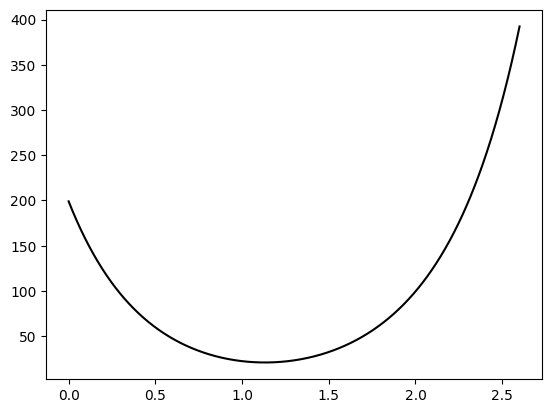

In [116]:
Lambda = np.linspace(0,2.6,1000)
z=np.zeros(np.size(Lambda));
G=np.random.normal(size=n);
mean=np.zeros(np.size(Lambda))
for j in range(N):
    G=np.random.normal(size=n);
    z=np.zeros(np.size(Lambda));
    for i in range(np.size(Lambda)):
        z[i]=approx_variance(Lambda[i],G);
        mean[i]=mean[i]-1/(j+1)*(mean[i]-z[i])
# plt.plot(Lambda,z,'red');
plt.plot(Lambda,mean,'black');

**Proposition :** *la dérivée peut s'écrire sous les deux formes suivantes*\n,
$$\frac{\partial}{\partial \lambda}Var\left(X_\lambda\right)
           =  \mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}
           =  - \mathbb{E}\left\{ G e^{-2\lambda G - \lambda^2} f^2(G+\lambda)\right\}$$
On a
$$\begin{align*}
\frac{\partial}{\partial \lambda}Var\left(X_\lambda\right)&= \frac{\partial}{\partial \lambda}\mathbb{E}\left\{e^{-\lambda G+\frac{\lambda^2}{2}}f^2(G)\right\}=\mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}
\end{align*}$$,
D'autre part, avec $h(x)=(\lambda - x)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(x)$,
$$\begin{align*},
\mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}&= \mathbb{E}\left\{h(G)\right\}\\
&=\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} h(G+\lambda)\right\}\\
&= - \mathbb{E}\left\{ G e^{-2\lambda G - \lambda^2} f^2(G+\lambda)\right\}
\end{align*}$$

On vérifie ce fait par simulation en tracant les deux approximationsn Monte-Carlo de la dérivées.

On chercher à résoudre $\frac{\partial}{\partial \lambda}Var\left(X_\lambda \right)=0$ en utilisant la première représentation de la dérivée. \n",

On prendra $K=200$.

Pour cela, on pose $X_0=0$, puis,
$$X_{n+1}=X_n-\gamma_n (X_n - G_{n+1})e^{-X_n G_{n+1} + \frac{X_n^2}{2}} f^2(G_{n+1})$$,
Ou bien,

$$X_{n+1}=X_n +\gamma_n G_{n+1} e^{-2X_n G_{n+1} - X_n^2} f^2(G_{n+1}+X_n)$$


On remarque alors que l'algorithme ne converge pas, $f$ n'est pas continue ?

On implémente cet algorithme en ramenant  $X_n$ une valeur initiale commune lorsque $X_n$ dépasse la valeur de  5  (procédure dite de *projection de Chen*). On peut voir que l'algorithme converge

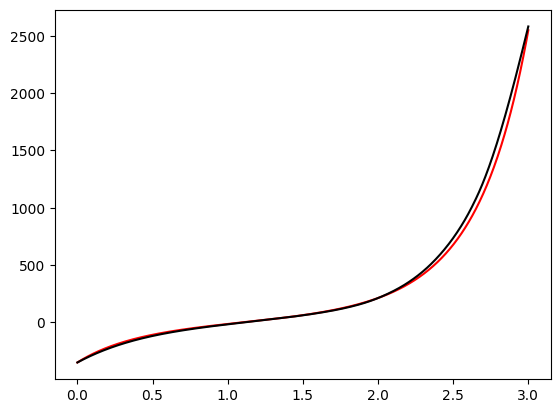

In [14]:
def approx_1_derivee_variance(Lambda):
    #G=np.random.normal(size=2000)
    Y=(Lambda-G)*np.exp(-Lambda*G+Lambda**2*0.5)*f(G)**2
    return np.mean(Y);

def approx_2_derivee_variance(Lambda):
    #G=np.random.normal(size=2000)
    Y=-G*np.exp(-2*Lambda*G-Lambda**2)*f(G+Lambda)**2
    return np.mean(Y);


K=100;
Lambda=np.linspace(0,3,n)
z1=np.zeros(np.size(Lambda));
z2=np.zeros(np.size(Lambda));
G=np.random.normal(size=n);
mean=np.zeros(np.size(Lambda))
for i in range(np.size(Lambda)):
    z1[i]=approx_1_derivee_variance(Lambda[i]);
    z2[i]=approx_2_derivee_variance(Lambda[i]);
plt.plot(Lambda,z1,'red');
plt.plot(Lambda,z2,'black');

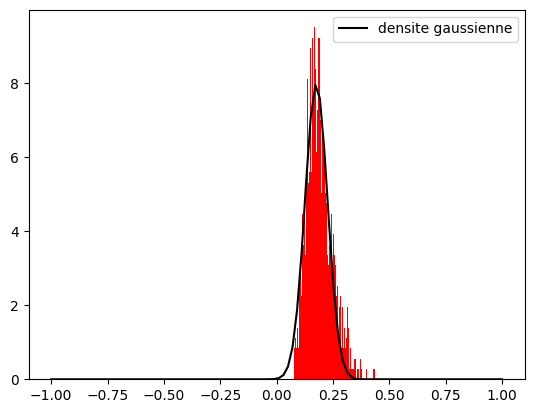

In [15]:

z=np.zeros(1000);
for i in range(1000):
    G=np.random.normal(size=n);
    X=algorithme_rm_chen(0.1,MAX,n,F_BS,G)
#     X=algorithme_rm(x_0,n,C,Beta,F1,G)
    z[i]=X[-1]
    
# La densité gaussienne de référence
x = np.linspace(-1,1,100)
densiteGaussienne = 1./(0.05*np.sqrt(2*np.pi))*np.exp(-0.5*((x-sigma_prim)/0.05)**2)
plt.plot(x, densiteGaussienne,color='black', label="densite gaussienne")
plt.legend(loc="best")

plt.hist(z, color="red", density="True", bins=100, label="erreur normalisee");

# Playing around

## 1 
On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:
 
$$dS_t=rS_t+\sigma dB_t$$



On alors avec $d_t=1/n$ et $\theta_n=\frac{1}{\sqrt{n}}$
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=-S_nnr-\sigma \frac{n}{\sqrt{n}} G_{n+1}$$



In [98]:
def algorithme_rm_chen_martingal(x_0,MAX,t,F,G):
    X=np.zeros(t);
    X[0] = x_0;
    for i in range(1,t-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i],i)
        if(abs(X[i+1]) >= MAX): 
            X[i+1]=0
    return X


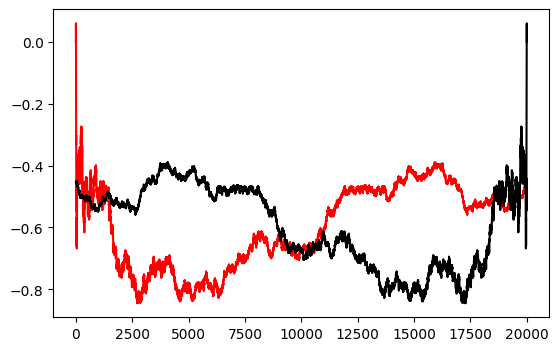

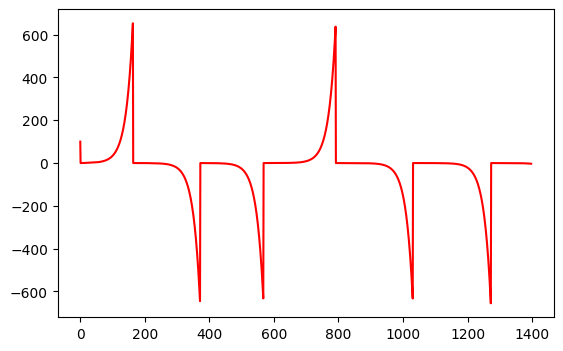

In [401]:
n=10000


def F(x,U,n):
    return x*r/n+sigma_prim*1*np.sqrt(n)*U


def Bi(x,U,n):
    return x*r*1+sigma_prim*U


def B(x,u,i):
    return -x*r*i-sigma_prim*np.sqrt(i)*u

G=np.random.normal(size=n)

def algorithme_rm_chen_Price(x_0,MAX,n,F,G):
    X=np.zeros(n);
    X[0] = x_0;
    for i in range(1,n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i],i)
        if(abs(X[i+1]) >= MAX): 
            X[i+1]=0
    return X


target=10
G=np.random.normal(size=2*n)
G2=np.random.normal(size=2*n)
Y=algorithme_rm_chen_martingal(0,2.5*S_0,2*n,F,G)
u=algorithme_rm_chen_martingal(0,2.5*S_0,2*n,F,G)
Z=[x for x in reversed(u)]
plt.figure().set_figheight(4)
plt.plot(Y,'red',Z,'black')
#plt.plot(Z,'black')
plt.show()

n=699
cible =S_0
N=int(2*n)
# G=np.random.normal(size=N)
Y=algorithme_rm_chen_martingal(cible,cible*6.6,N,B,G)
f=max(Y)
U=[y/f for y in Y]
#plt.figure().set_figwidth(4)#(figsize=(6,6))
plt.figure().set_figheight(4)
plt.plot(Y,'red')
plt.show()

## 2

Sinon si on prends le modele de black scholes
$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$
Donc 
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=\frac{S_n}{n}\left(r+\sigma \sqrt{n} G_{n+1}\right)$$
et si on fixe $n=N (\text{ maturité } T)$ et on prends
$$B(S_n,G_{n+1})=\frac{S_n}{N}\left(r+\sigma \sqrt{N} G_{n+1}\right)$$

On trouve le processus suivant :

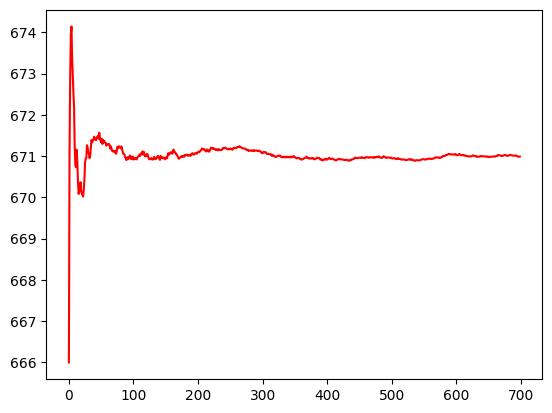

In [316]:
def B(x,u):
    return x*(r/n+sigma_prim/n*np.sqrt(n)*u)


G=np.random.normal(size=n)


cible =666
Y=algorithme_rm_chen(cible,cible*6.6,n,B,G)
plt.plot(Y,'red')

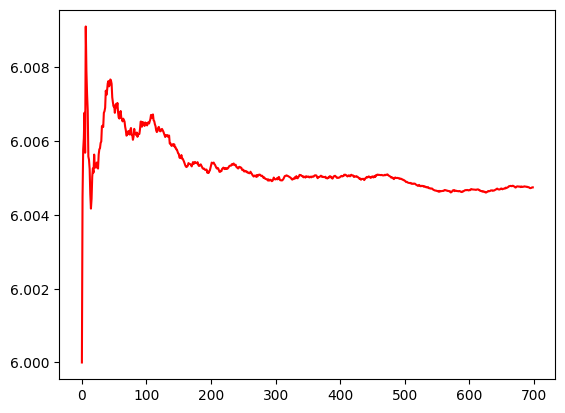

In [321]:
def B(x,U):
    return x*r/n+sigma*1/np.sqrt(n)*U

cible=6
G=np.random.normal(size=n)

Y=algorithme_rm_chen(cible,cible*6,n,B,G)

plt.plot(Y,'red')

# END 

# Modèle de Black and Scholes et Ajustement de Valorisation stochastique

## Modèle de black scholes 

### Méthode Monte Carlo 
Soit 
$$S_t=\frac{1}{r}\sigma dB_t-\frac{1}{r}dS_t$$

On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

Où

$$X_t=ln(S_t)$$

donc

$$dX_t=(r-\frac{\sigma^2}{2})dt+\sigma dB_t$$












Soit $Y_t=exp(-rt+X_t)=exp(-rt)S_t$
donc,

$$dY_t=X_tY_tdt+Y_tdX_t+\frac{1}{2}\sigma^2Y_tdt=Y_t(r-\frac{\sigma^2}{2}dt+\sigma dB_t)+\frac{1}{2}\sigma^2Y_tdt=X_tY_tdt+Y_t\left(rdt+\sigma dB_t\right)$$

donc

$$dY_t=X_tY_tdt+exp(-rt)dS_t=exp(-rt)(S_tln(S_t)+dS_t)$$


On a alors,$$X_{n+1}-X_{n}=(r-\frac{\sigma^2}{2})\frac{1}{n}+\sigma \frac{1}{\sqrt{n}}G=-\theta_nB(S_n,G_{n+1})$$









$$\begin{cases}
      r= 5\text{% : taux d'actualisation} & \\
      \sigma \text{ : la volatilité} & \\
      B_t \text{ : Un mouvement brownien standard, } B_t \sim \mathcal{N}(0,\,t) &
    \end{cases}$$

la solution de cette EDS est la diffusion suivante $\forall t\geq 0$ et $\sigma \in [0,1]$:

$$S_t(\sigma)=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma B_t\right\}=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma \sqrt{t} G\right\}$$

On définit alors le prix d'un call europeen dont le sous jacent est A de la maniere suivante:

$$C(\sigma)=\mathbb{E}\left[e^{-rT}(S_T(\sigma)-K)_+\right]=\mathbb{E}\left[\mathbb{1}_{e^{-rT}(S_T(\sigma)-K)>0}e^{-rT}(S_T(\sigma)-K)\right]$$


On a $\forall t>0$

$$e^{-rT}(S_T(\sigma)-K)>0 \iff S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}>0$$

$$\iff S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}>0$$

On a aussi avec $d_t=1/n$ et $\theta_n=\frac{1}{\sqrt{n}}$
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=\frac{S_n}{n}\left(r+\sigma \sqrt{n} G\right)$$

soit la suite de variable aleatoires 
$$V_i=(S_T-K)_{+}=\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G_i\right\}-K\right)_{+}$$
avec
$$t_i=\frac{i}{n} \text{  pour 0$\leq$ i$\leq$ n}$$

Soit
$$M_n=\frac{V_0+....+V_n}{n} \text{, alors, $M_n$ converge présque surement vers } C \text{ le prix d'un call}$$

On a avec $\gamma_n=\frac{1}{n+1}$

$$M_{n+1} = M_n -\gamma_n \left(M_n - V_{n+1}\right)= M_n -\gamma_n F \left(M_n , V_{n+1}\right)$$
En effet,

$$\begin{align*}
M_{n+1}-M_n&=\frac{n\sum_{i=1}^{n+1}V_i-(n+1)\sum_{i=1}^nG_i}{n(n+1)}&\\
&=\frac{V_{n+1}}{n+1}-\frac{M_n}{n+1}&\\
&=-\gamma_n(M_n-V_{n+1})
\end{align*}$$

Soit $f(x)=x-C$  et $x'$ tel que $f(x')=x'-C=0$ et $G$ une gaussienne centrée réduite, donc $\mathbb{E}[G]=0$ et $Var[G]=1$.

On a alors avec $F(x,G)=x-H(\sigma,G)$

avec

$$F(\sigma,G)=e^{-rT}\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G\right\}-K\right)_+$$
donc

$$f(x)=\mathbb{E}[F(x,G)]=x-C$$


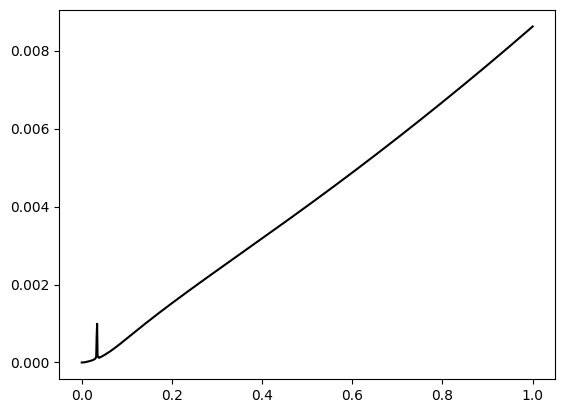

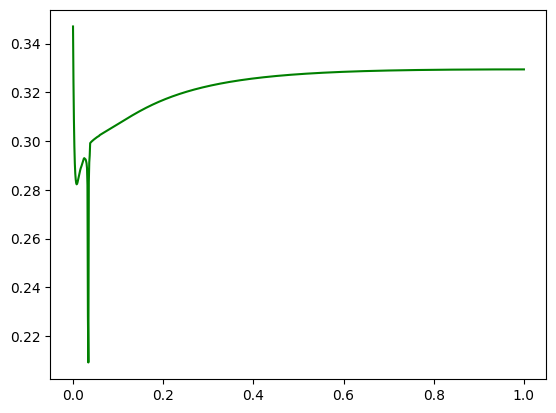

In [412]:
c_=np.linspace(0,1,1000)
Varc=[]
espc=[]
Gh=np.random.normal(size=6000)
for c in (c_):
    #Gh=np.random.normal(size=6000) Meme alogo mais differents c
    Xh=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,F_BS,G2)#algorithme_rm_hyper(x_0,n,h,F1,Gh)
    Xtr=Xh[int(len(Xh)/2):len(Xh)]
    Varc.append(np.var(Xtr))
    espc.append(np.mean(Xtr))
    
plt.plot(c_,Varc,'black',label="C")
plt.show()
#plt.legend(loc="best")
plt.plot(c_,espc,'green')
plt.show()

**Théorème:**(Loi des grands nombres pour les martingale)

Soit $(S_n)_{n\geq0}$ une martingale de carrée integrable, on a alors:

 +*Sur* $\langle S\rangle_\infty:=\lim_{n\rightarrow \infty}\langle S\rangle_n<\infty$ $S_n$ *converge présque surement vers une variable :$S_\infty$,

+*Sur* $\{\langle S\rangle_\infty=\infty\}$
          $$\lim_{n\rightarrow\infty}\frac{S_n}{\langle S\rangle_n}=0 \text{ , p.s}$$

En plus, si $a(t)$ est une fonction positive, croissante telle que 

$\int_0^{\infty}\frac{dt}{1+a(t)}<\infty$, 
alors,
       $$\lim_{n\rightarrow \infty}\frac{S_n}{\sqrt{a(\langle S\rangle_n)}}=0\text{ , p.s}$$
       

**Proposition:** Avec les même notations, on pose $S_0=0$ et $S_n=nM_n, \forall n >0$, alors $(S_n)_{n\geq0}$ est une martingale,et $\langle S\rangle_n=n$

On a

$$\begin{align*}
        \mathbb{E}\left\{S_{n+1}\mid\mathcal{F}_n\right\}&=\mathbb{E}\left\{V_1+...+V_V+V_{n+1}\mid\mathcal{F}_n\right\}\\
 &=V_1+...+V_n+C=S_n+C
 \end{align*}$$
 

Donc $(S_n)_{n\\geq0}$ est une martingale, en plus $\langle S\rangle_0=0$, et $\forall n>0$


Avec $g(x)=e^{-\lambda x+\frac{\lambda^2}{2}}f^2(x)$,

$$\langle S\rangle_{n+1}-\langle S\rangle_n=\mathbb{E}\left\{(S_{n+1}-S_n)^2\mid\mathcal{F}_n\right\}=Var\{V_{n+1}\}=\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2$$

Donc


$$\langle S\rangle_n=\sum_{k=0}^{n-1}\langle S\rangle_{k+1}-\langle S\rangle_k=n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)$$



Donc $\langle S\rangle_\infty=\infty$, et en utilisant le théorème précédant on retrouve la loi forte des grands nombre. \n",

On a alors
$$\lim_{n\rightarrow\infty}\frac{V_1+...+V_n}{n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)}=C \text{  p.s}$$


In [168]:

def approx_variance(Lambda,G):
    # ATTENTION: G est un vecteur echantillon de gaussiennes
    return(np.mean(np.exp(-Lambda*G+0.5*Lambda**2)*f(G)**2)-(np.mean(f(G))**2)) 

G=np.random.normal(size=n)

u=approx_variance(1,G)

TypeError: 'numpy.float64' object is not callable

In [167]:
def algorithme_rm_chen_MGL(x_0,MAX,n,F):
    G=np.random.normal(size=n)
    X=np.zeros(n);
    X[0] = x_0;
    for i in range(n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
        if(abs(X[i+1]) >= MAX): 
            X[i+1]=0 
    return X


def F_BS(x,U):
    return np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K,0)-C_m*u#approx_variance(1,G)


cible=sigma_prim
Y=algorithme_rm_chen_MGL(cible,cible*6,66*n,F_BS)

plt.plot(Y,'red')

ValueError: setting an array element with a sequence.